# Exploratory Data Analysis on H1N1 and Seasonal Flu Vaccine Data


#### Summary of this notebook
Running this notebook will save a `train_clean.csv` file in the `../data/` directory. The cleaned fill will contain all the features and labels for vaccinated and unvaccinated respondents. 

The notebook also visualizes most of the features to show how many respondents of the survey were vaccinated with the H1N1 and Seasonal flu vaccines in each group of the feature. 

Finally, the notebook replaces null values using the methods described below. 

##### **Summary of actions taken to impute nulls**
1. **Method 1** : If more than 5% of observations are null values (i.e, 1000), and the feature is ordinal in nature, nulls will be replaced proportionally with respect to a grouping variable (selected as `age_group` for this dataset)
2. **Method 2** : If the feature is numerical, nulls are replaced by median value
3. **Method 3** : If the feature is categorical, nulls are replaced by a new category, `no_response`

Feature| Null Count| Replacement Method
-------|-----------|-------------------
employment_occupation|13470| 'no_response'
employment_industry|13330| 'no_response'
health_insurance|12274| 'no_response'
income_poverty|4423| 'no_response'
doctor_recc_h1n1|2160| 'no_response'
doctor_recc_seasonal|2160| 'no_response'
rent_or_own|2042| 'no_response'
employment_status|1463| 'no_response'
marital_status|1408| 'no_response'
education|1407| 'no_response'
chronic_med_condition|971| 'no_response'
child_under_6_months|820| by `age_group`
health_worker|804| 'no_response'
opinion_seas_sick_from_vacc|537| median
opinion_seas_risk|514| median
opinion_seas_vacc_effective|462| median
opinion_h1n1_sick_from_vacc|395| median
opinion_h1n1_vacc_effective|391| median
opinion_h1n1_risk|388| median
household_adults|249| by `age_group`
household_children|249| by `age_group`
behavioral_avoidance|208| median
behavioral_touch_face|128| median
h1n1_knowledge|116| median
h1n1_concern|92| median
behavioral_large_gatherings|87| median
behavioral_outside_home|82| median
behavioral_antiviral_meds|71| median
behavioral_wash_hands|42| median
behavioral_face_mask|19| median


**Library Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [2]:
def fill_nulls(var, grouping_var):
    '''
    Fills null values in variable 'var', based on proportions of var values in groups of grouping variable 'grouping_var'
    Returns 'var' as a series with nulls replaced
    
    var: variable in which nans need to be filled
    grouping_var : grouping variable used to determine best value to fill
    '''  
    import random
    import math
    
    # group vars
    grouped_df = pd.crosstab(index=grouping_var, columns=var,margins=True,normalize='index').round(3)
    
    # establish values to fill nulls with and groups to use
    values = list(grouped_df.columns)
    groups = list(grouped_df.index)
    groups.remove('All')
    
    # access each group one at a time and replace nulls there
    for group in groups:
        probabilities = grouped_df.loc[group, :].values
        
        # find indexes within that group that are nulls
        mask = ((grouping_var==group) & (var.isna()))
        nan_indexes = list(var[mask].index)
        random.shuffle(nan_indexes)
        
        # calculate the number of observations that match the corresponding percentage of values
        # for instance: if the percentage of 18-25 year olds that earl above $75k is 0.2, how many 
        # observations that have null values is that?
        
        lengths = [math.ceil(round(p,2)*len(nan_indexes)) for p in probabilities]
        
        # begin replacements
        for i in range(len(lengths)):
            sample = var[mask].sample(n=lengths[i])
            nulls_to_fill = list(sample.index)
            var.loc[nulls_to_fill] = values[i]
            proba = list(probabilities)
            maxprob_val = values[proba.index(max(proba))]
        var[mask] = maxprob_val
    return var

In [62]:
def visualize(df, var):
    num_nulls = df[var].isnull().sum() # count number ofnulls

    # copy data to variable that can be modified without modifying original dataframe
    var_data = df[[var, 'h1n1_vaccine', 'seasonal_vaccine']].copy() 

    # replace nulls with appropriate value
    var_data[var].fillna('no_response', inplace=True)

    # visualize results
    if df[var].dtypes != 'O':
        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].sum().plot(kind='bar', ax=ax[0])
        ax[0].set_ylabel("Number of vaccinated individuals", size=12)
        ax[0].set_xlabel(f'feature {var} categories', size=12)
        ax[0].set_title(f'feature : {var} : nulls : {num_nulls}', size=18);

        df[var].plot(kind='hist', ax=ax[1])
        ax[1].set_title(f'Distribution of values. Median = {df[var].median()}', size=18)
        ax[1].set_xlabel('Values', size=12)
        ax[1].set_ylabel('Counts', size=12)
    else:
        var_data.groupby(var)[['h1n1_vaccine', 'seasonal_vaccine']].sum().plot(kind='bar')
        plt.ylabel("Number of vaccinated individuals", size=12)
        plt.xlabel(f'feature {var} categories', size=12)
        plt.title(f'feature : {var} : nulls : {num_nulls}', size=18);

In [60]:
def null_replacement(data, var):
    visualize(data, var)
    print(f'Number of Nulls: {data[var].isna().sum()},\n Value Counts : \n{data[var].value_counts()}')

## Import data

In [4]:
features = pd.read_csv('../data/training_set_features.csv')
labels = pd.read_csv('../data/training_set_labels.csv')

In [5]:
features.shape

(26707, 36)

In [6]:
# merge features and labels into a single dataframe
data = pd.merge(left=features, right=labels, on='respondent_id')

In [12]:
# look for nulls
pd.DataFrame(data=data.isna().sum(), columns=['null_count']).sort_values('null_count', ascending=False)

,null_count
employment_occupation,13470
employment_industry,13330
health_insurance,12274
income_poverty,4423
doctor_recc_h1n1,2160
doctor_recc_seasonal,2160
rent_or_own,2042
employment_status,1463
marital_status,1408
education,1407


#### **Print out the percentage of nulls that belong to the positive class of each target variable**

**for instance:**

```
h1n1_concern    
h1n1_vaccine        0.173913    
seasonal_vaccine    0.456522  
dtype: float64  
Nulls : 92  
```
**means:**
The variable `h1n1_concern` has 92 null values. 17% of these nulls are in the positive class for `h1h1_vaccine` and the rest in teh negative class. 45% of the 92 nulls are in the positive class for `seasonal_vaccine` and the rest belong to the negative class. 

This is just to check if there are any null values that are more likely to belong to one class versus the other which will help us determine how we should replace them. 


In [13]:
column = []
h1n1 = []
sea = []
nulls = []

for col in list(data.columns):
    if data[col].isna().sum() > 0:
        column.append(col)
        h1n1.append(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean()['h1n1_vaccine']) 
        sea.append(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean()['seasonal_vaccine'])
        nulls.append(data[col].isna().sum())
        # print(col)
        # print(data[data[col].isnull()][['h1n1_vaccine', 'seasonal_vaccine']].mean())
        # print(f'Nulls : {data[col].isna().sum()}')
        # print('--------------------------\n--------------------------')
        
null_df = pd.DataFrame({'column' : column, 'h1n1': h1n1, 'seasonal' : sea, 'nulls' : nulls})
null_df.sort_values('nulls', ascending=False)

,column,h1n1,seasonal,nulls
29,employment_occupation,0.208909,0.508389,13470
28,employment_industry,0.207877,0.508102,13330
14,health_insurance,0.112759,0.424149,12274
22,income_poverty,0.189012,0.448338,4423
9,doctor_recc_h1n1,0.085648,0.352315,2160
10,doctor_recc_seasonal,0.085648,0.352315,2160
24,rent_or_own,0.193928,0.419197,2042
25,employment_status,0.185236,0.387560,1463
23,marital_status,0.181818,0.389205,1408
21,education,0.185501,0.385217,1407


## EDA and replacing nulls. 


##### h1n1_concern

Number of Nulls: 92,
 Value Counts : 
2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: h1n1_concern, dtype: int64


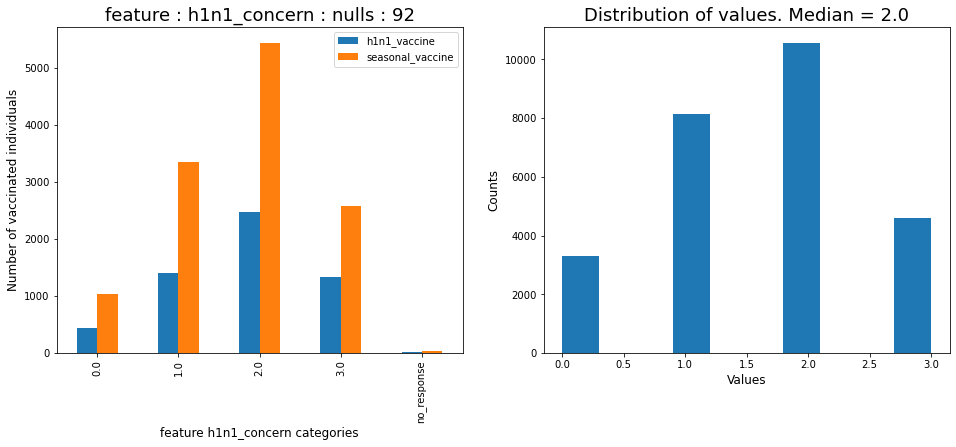

In [63]:
var = 'h1n1_concern'
null_replacement(data, var)

In [64]:
## replacing this with mode = 2.0

data['h1n1_concern'].fillna(2.0, inplace=True)
data['h1n1_concern'].isna().sum()

0

##### h1n1_knowledge

Number of Nulls: 116,
 Value Counts : 
1.0    14598
2.0     9487
0.0     2506
Name: h1n1_knowledge, dtype: int64


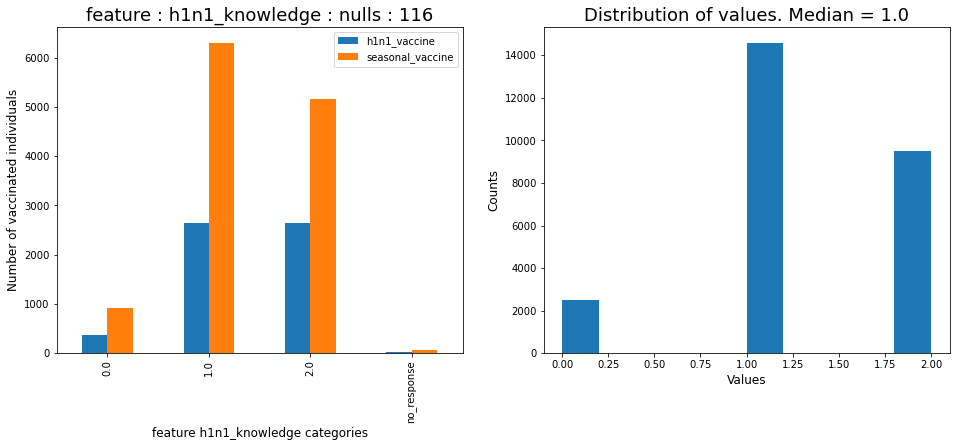

In [65]:
null_replacement(data, 'h1n1_knowledge')

In [66]:
## replacing this with median = 1.0

data['h1n1_knowledge'].fillna(1.0, inplace=True)
data['h1n1_knowledge'].isna().sum()

0

##### behavioral_antiviral_meds

Number of Nulls: 71,
 Value Counts : 
0.0    25335
1.0     1301
Name: behavioral_antiviral_meds, dtype: int64


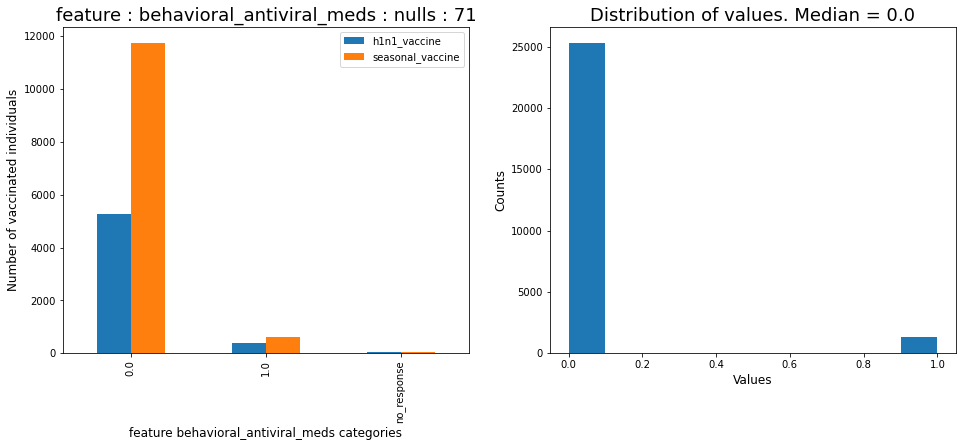

In [67]:
null_replacement(data, 'behavioral_antiviral_meds')

In [68]:
# fill nulls with 0.0
data['behavioral_antiviral_meds'].fillna(0.0, inplace=True)
data['behavioral_antiviral_meds'].isna().sum()

0

##### behavioral_avoidance

Number of Nulls: 208,
 Value Counts : 
1.0    19228
0.0     7271
Name: behavioral_avoidance, dtype: int64


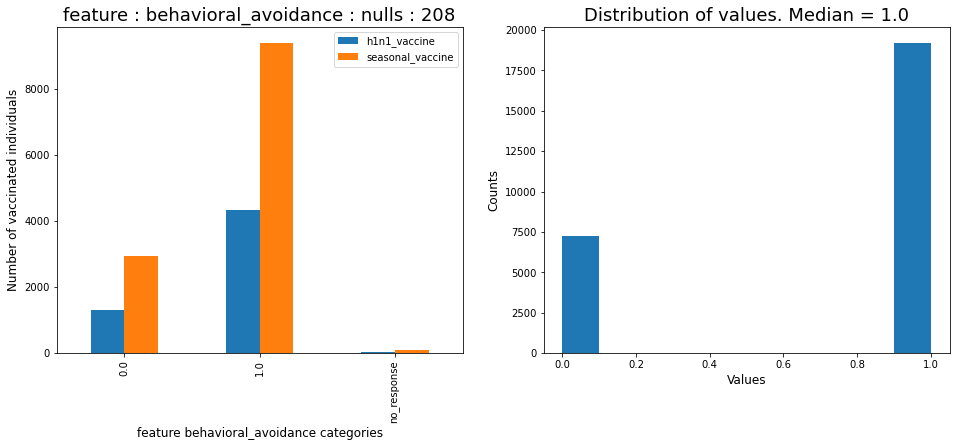

In [69]:
null_replacement(data, 'behavioral_avoidance')

In [70]:
# fill nulls with 1
data['behavioral_avoidance'].fillna(1.0, inplace=True)
data['behavioral_avoidance'].isna().sum()

0

##### behavioral_face_mask

Number of Nulls: 19,
 Value Counts : 
0.0    24847
1.0     1841
Name: behavioral_face_mask, dtype: int64


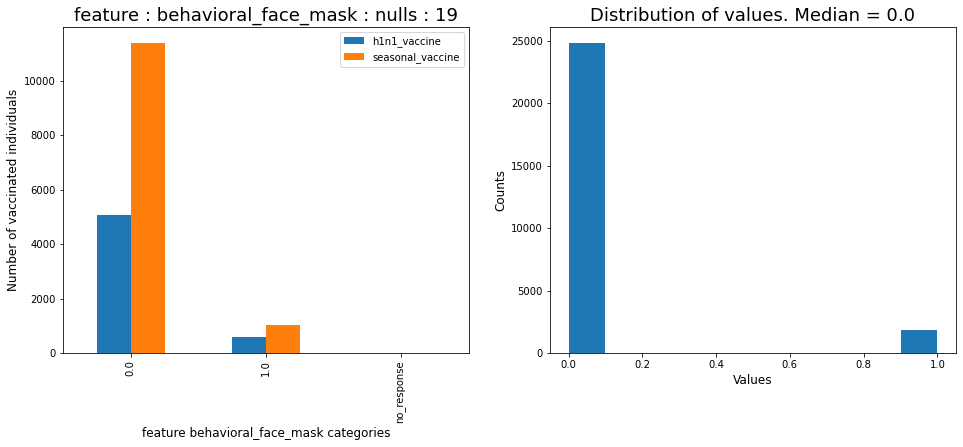

In [71]:
null_replacement(data, 'behavioral_face_mask')

In [72]:
# fill nulls with 0
data['behavioral_face_mask'].fillna(0, inplace=True)
data['behavioral_face_mask'].isna().sum()

0

##### behavioral_wash_hands

Number of Nulls: 42,
 Value Counts : 
1.0    22015
0.0     4650
Name: behavioral_wash_hands, dtype: int64


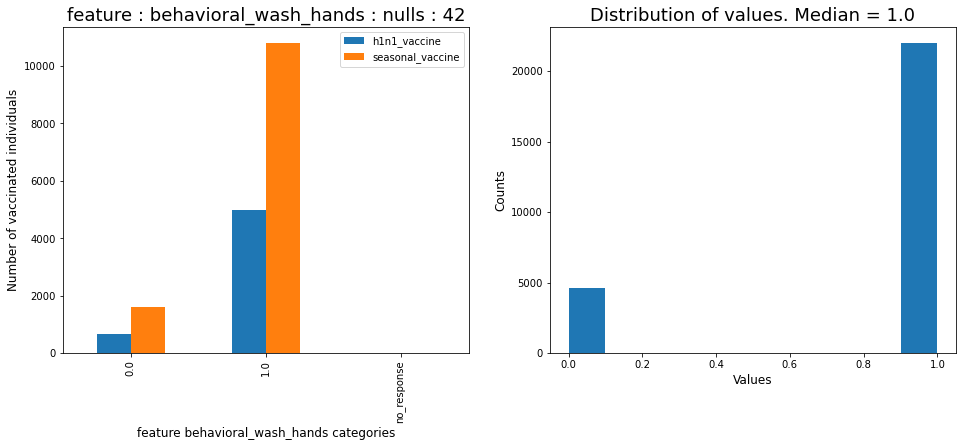

In [73]:
null_replacement(data, 'behavioral_wash_hands')

In [74]:
# fill nulls with 1
data['behavioral_wash_hands'].fillna(1.0, inplace=True)

In [75]:
data['behavioral_wash_hands'].isna().sum()

0

##### behavioral_large_gatherings

Number of Nulls: 87,
 Value Counts : 
0.0    17073
1.0     9547
Name: behavioral_large_gatherings, dtype: int64


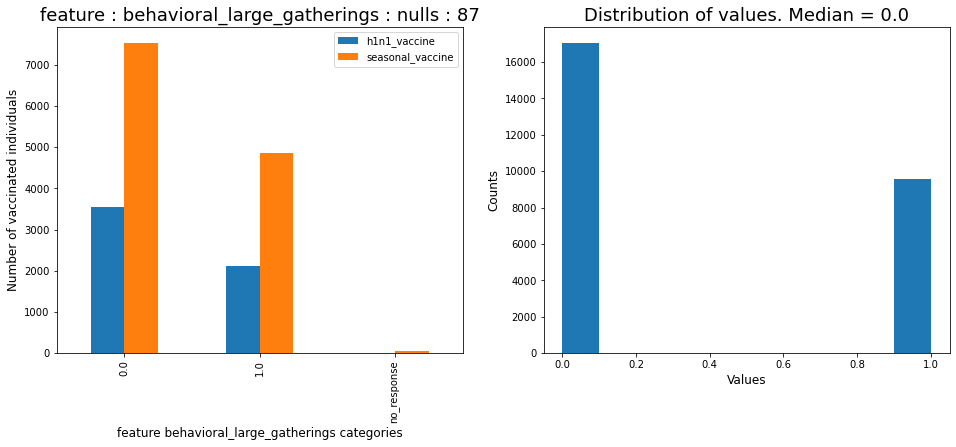

In [76]:
null_replacement(data, 'behavioral_large_gatherings')

In [77]:
# fill nulls with 0
data['behavioral_large_gatherings'].fillna(0, inplace=True)
data['behavioral_large_gatherings'].isna().sum()

0

In [96]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

##### behavioral_outside_home

Number of Nulls: 82,
 Value Counts : 
0.0    17644
1.0     8981
Name: behavioral_outside_home, dtype: int64


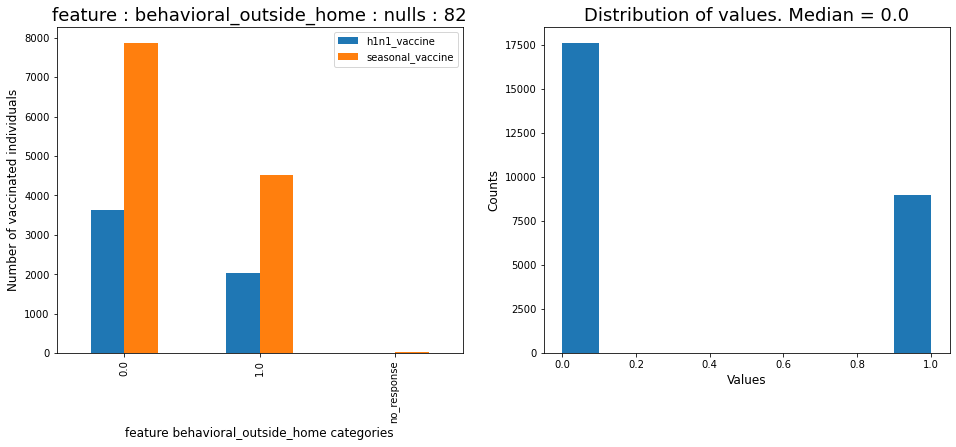

In [78]:
null_replacement(data, 'behavioral_outside_home')

In [79]:
# fill nulls with 0
data['behavioral_outside_home'].fillna(0, inplace=True)
data['behavioral_outside_home'].isna().sum()

0

##### behavioral_touch_face

Number of Nulls: 128,
 Value Counts : 
1.0    18001
0.0     8578
Name: behavioral_touch_face, dtype: int64


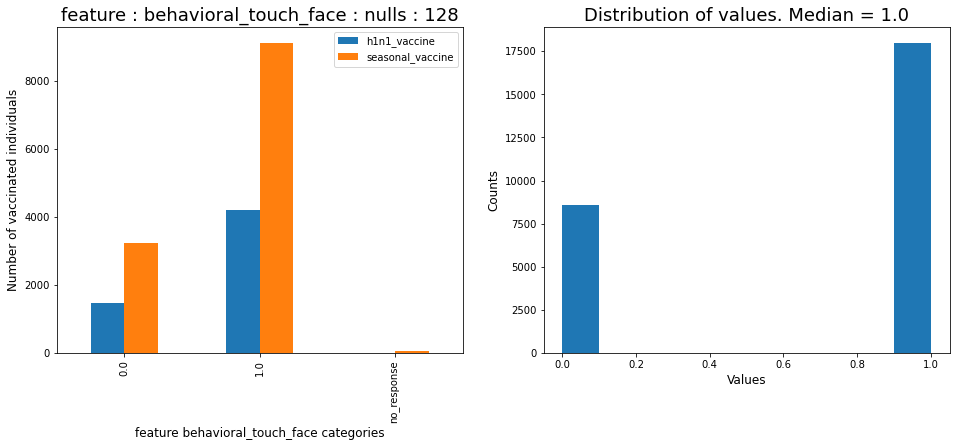

In [80]:
null_replacement(data, 'behavioral_touch_face')

In [81]:
# fill nulls with 1
data['behavioral_touch_face'].fillna(1, inplace=True)
data['behavioral_touch_face'].isna().sum()

0

##### doctor_recc_h1n1

Number of Nulls: 2160,
 Value Counts : 
0.0    19139
1.0     5408
Name: doctor_recc_h1n1, dtype: int64


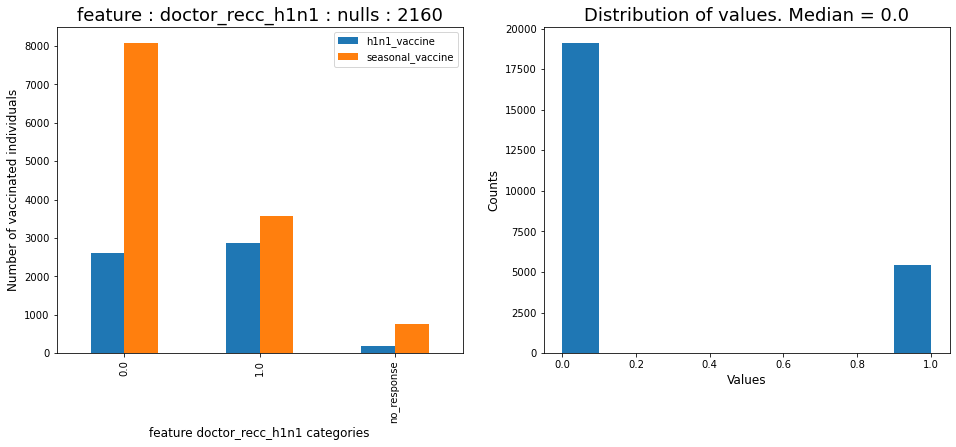

In [82]:
null_replacement(data, 'doctor_recc_h1n1')

In [83]:
# since there are a lot of nulls, we will be creating a no_response category to replace all the nulls
data['doctor_recc_h1n1'].fillna('no_response', inplace=True)
data['doctor_recc_h1n1'].isna().sum()

0

##### doctor_recc_seasonal

Number of Nulls: 2160,
 Value Counts : 
0.0    16453
1.0     8094
Name: doctor_recc_seasonal, dtype: int64


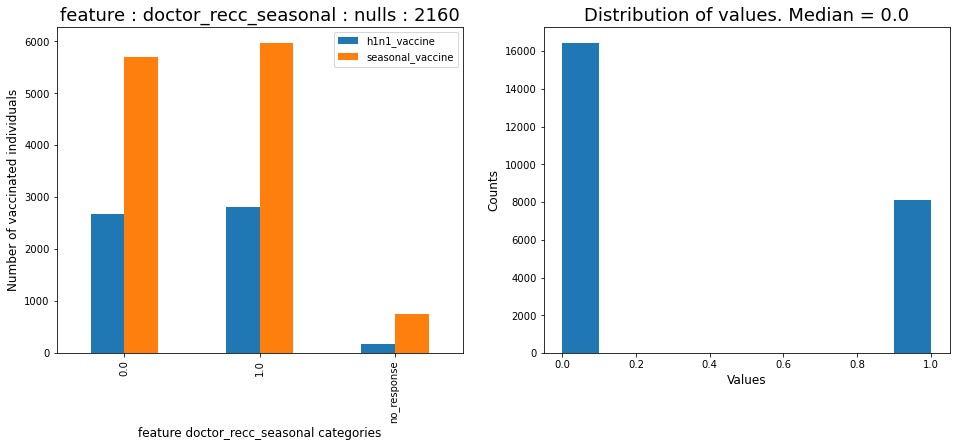

In [84]:
null_replacement(data, 'doctor_recc_seasonal')

In [85]:
# since there are a lot of nulls, we will be creating a no_response category to replace all the nulls
data['doctor_recc_seasonal'].fillna('no_response', inplace=True)
data['doctor_recc_seasonal'].isna().sum()

0

##### chronic_med_condition

Number of Nulls: 971,
 Value Counts : 
0.0    18446
1.0     7290
Name: chronic_med_condition, dtype: int64


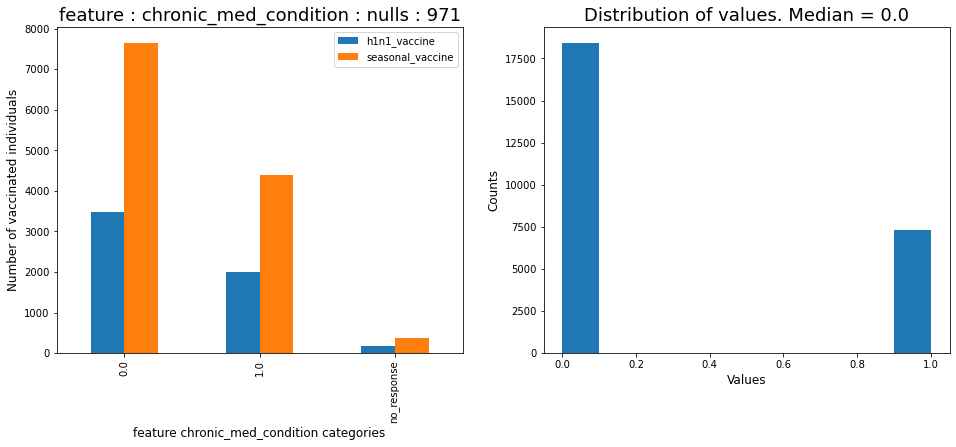

In [86]:
null_replacement(data, 'chronic_med_condition')

In [87]:
# since there are a lot of nulls, we will be creating a no_response category to replace all the nulls
data['chronic_med_condition'].fillna('no_response', inplace=True)
data['chronic_med_condition'].isna().sum()

0

##### opinion features, all nulls are replaced with median value

In [88]:
#'opinion_h1n1_vacc_effective' - There are 391 null values. The median is 4. Replace missing values with 4. 
data['opinion_h1n1_vacc_effective'].fillna(4, inplace = True)
#'opinion_h1n1_risk' There are 388 null values. The median is 2. Replace missing values with 2. 
data['opinion_h1n1_risk'].fillna(2, inplace = True)
#'opinion_h1n1_sick_from_vacc' There are 395 nulls values. The median is 2. Replace missing values with 2. 
data['opinion_h1n1_sick_from_vacc'].fillna(2, inplace = True)
# 'opinion_seas_vacc_effective'There are 462 null values.  The median is 4. Replace missing values with 4. 
data['opinion_seas_vacc_effective'].fillna(2, inplace = True)
#'opinion_seas_risk' There are 514 null values. The median is 2. Replace missing values with 2. 
data['opinion_seas_risk'].fillna(2, inplace = True)
# 'opinion_seas_sick_from_vacc' There are 537 null values. The median is 2. Replace missing values with 2. 
data['opinion_seas_sick_from_vacc'].fillna(2, inplace = True)

##### child_under_6_months

Number of Nulls: 820,
 Value Counts : 
0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64


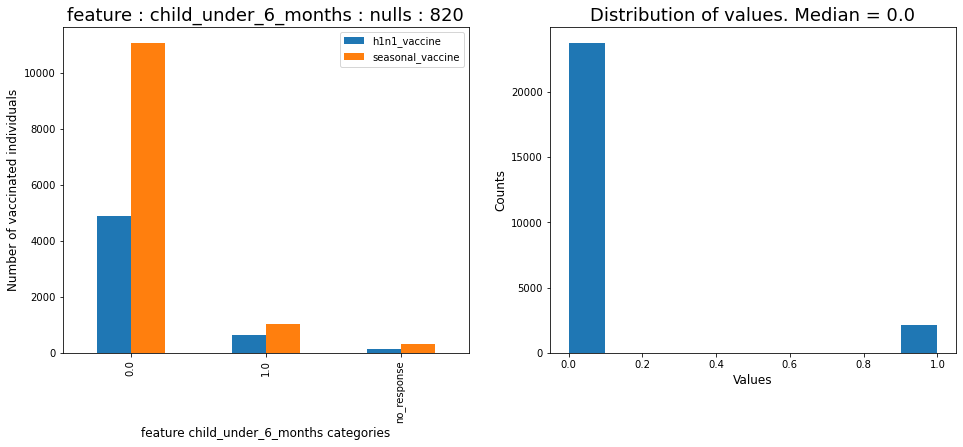

In [89]:
null_replacement(data, 'child_under_6_months')

In [109]:
pd.crosstab(index=data['age_group'], columns=data['child_under_6_months'],margins=True,normalize='index').round(3)

child_under_6_months,0.0,1.0
age_group,,
18 - 34 Years,0.865,0.135
35 - 44 Years,0.910,0.090
45 - 54 Years,0.924,0.076
55 - 64 Years,0.922,0.078
65+ Years,0.953,0.047
All,0.917,0.083


In [110]:
pd.crosstab(index=data['age_group'], columns=data['child_under_6_months'].fillna('no_response'),margins=True,normalize='index').round(3)

child_under_6_months,0.0,1.0,no_response
age_group,,,
18 - 34 Years,0.831,0.130,0.039
35 - 44 Years,0.873,0.087,0.040
45 - 54 Years,0.898,0.074,0.028
55 - 64 Years,0.901,0.076,0.023
65+ Years,0.927,0.046,0.027
All,0.889,0.080,0.031


In [90]:
# replacing nulls based on the distribution of responses among different age groups
data['child_under_6_months'] = fill_nulls(var=data['child_under_6_months'], grouping_var=data['age_group'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_34432/2333361200.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[mask] = maxprob_val


##### health_insurance

Number of Nulls: 12274,
 Value Counts : 
1.0    12697
0.0     1736
Name: health_insurance, dtype: int64


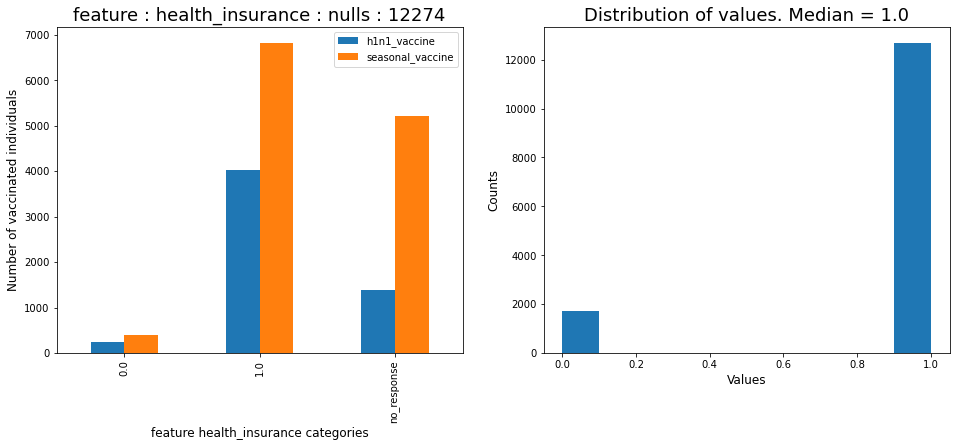

In [91]:
null_replacement(data, 'health_insurance')

Number of Nulls: 0,
 Value Counts : 
yes            12697
no_response    12274
no              1736
Name: health_insurance, dtype: int64


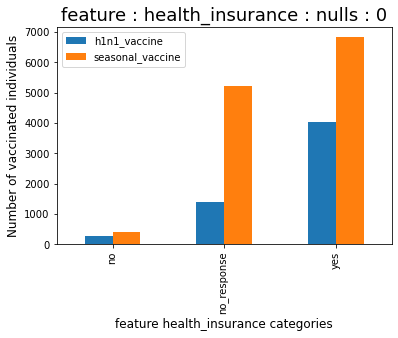

In [92]:
data['health_insurance'].fillna('no_response', inplace=True)
data['health_insurance'].replace({0 : 'no', 1 : 'yes'}, inplace=True)
null_replacement(data, 'health_insurance')

##### health_worker

Number of Nulls: 804,
 Value Counts : 
0.0    23004
1.0     2899
Name: health_worker, dtype: int64


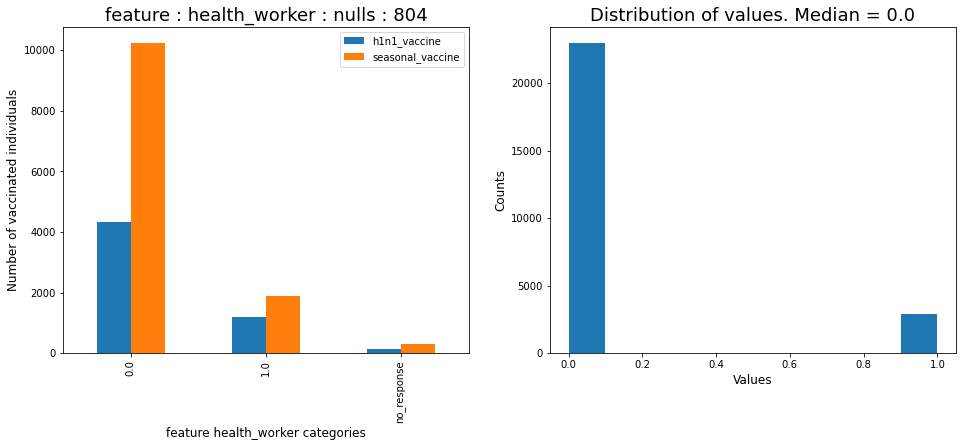

In [93]:
null_replacement(data, 'health_worker')

Number of Nulls: 0,
 Value Counts : 
no             23004
yes             2899
no_response      804
Name: health_worker, dtype: int64


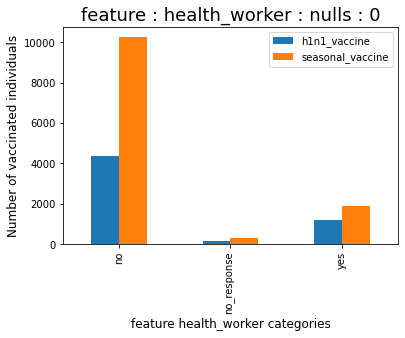

In [94]:
data['health_worker'].fillna('no_response', inplace=True)
data['health_worker'].replace({0 : 'no', 1 : 'yes'}, inplace=True)
null_replacement(data, 'health_worker')

##### education

Number of Nulls: 1407,
 Value Counts : 
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64


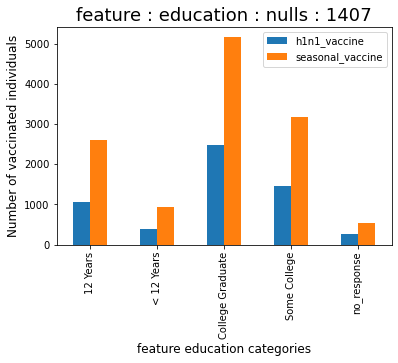

In [95]:
null_replacement(data, 'education')

In [96]:
pd.crosstab(index=data['age_group'], columns=data['education'],margins=True,normalize='index').round(4)*100

education,12 Years,< 12 Years,College Graduate,Some College
age_group,,,,
18 - 34 Years,22.84,10.39,35.08,31.70
35 - 44 Years,16.58,7.08,50.00,26.34
45 - 54 Years,21.57,6.81,42.60,29.02
55 - 64 Years,21.47,7.20,44.54,26.79
65+ Years,28.60,13.47,32.18,25.76
All,22.91,9.34,39.91,27.84


In [97]:
data['education'].fillna('no_response', inplace=True)

In [98]:
data['education'].isna().sum()

0

##### sex

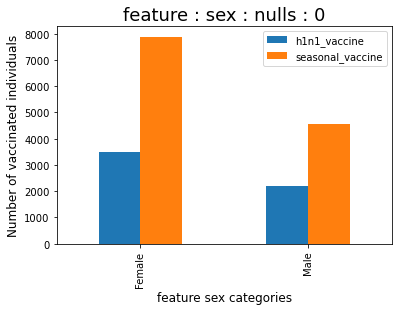

In [99]:
var = 'sex'

visualize(data, var)

##### income poverty

Number of Nulls: 0,
 Value Counts : 
<= $75,000, Above Poverty    12777
> $75,000                     6810
no_response                   4423
Below Poverty                 2697
Name: income_poverty, dtype: int64


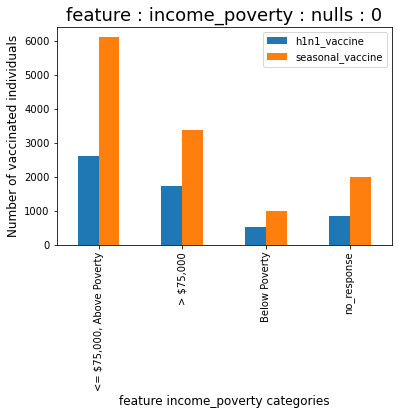

In [124]:
null_replacement(data, 'income_poverty')

In [101]:
data['income_poverty'].fillna('no_response', inplace=True)

##### marital_status

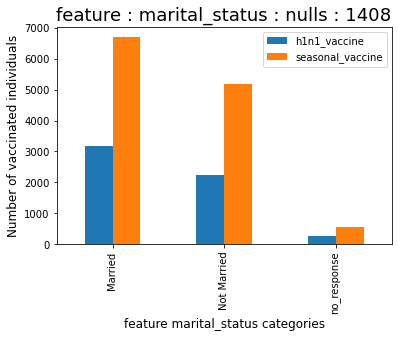

In [102]:
visualize(data, 'marital_status')

In [103]:
data['marital_status'].fillna('no_response', inplace=True)

##### employment_occupation

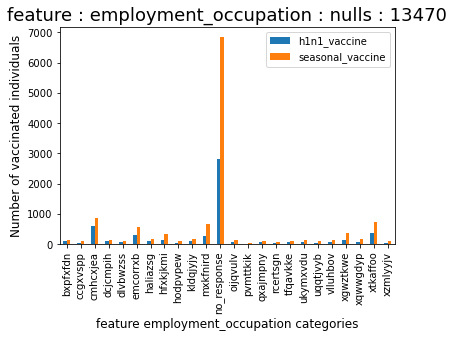

In [104]:
visualize(data, 'employment_occupation')

In [105]:
data['employment_occupation'].fillna('no_response', inplace=True)

##### employment_industry

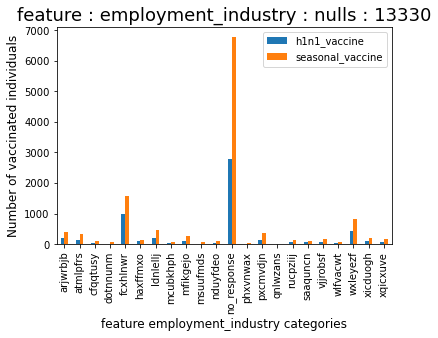

In [106]:
visualize(data, 'employment_industry')

In [107]:
data['employment_industry'].fillna('no_response', inplace=True)

##### household_children

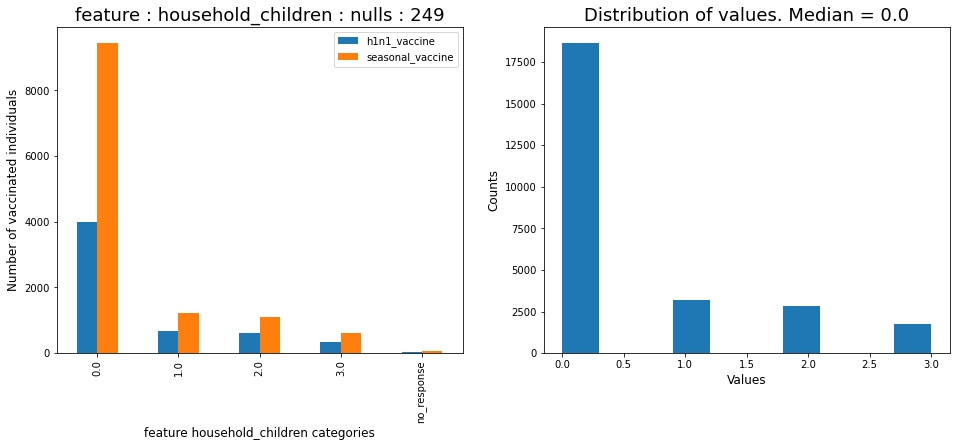

In [108]:
visualize(data, 'household_children')

In [109]:
pd.crosstab(index=data['age_group'], columns=data['household_children'],margins=True,normalize='index').round(4)*100

household_children,0.0,1.0,2.0,3.0
age_group,,,,
18 - 34 Years,50.60,19.33,17.64,12.43
35 - 44 Years,30.48,20.16,29.44,19.92
45 - 54 Years,63.33,18.17,13.42,5.08
55 - 64 Years,90.70,6.11,2.01,1.17
65+ Years,96.65,2.15,0.69,0.51
All,70.57,12.00,10.82,6.60


In [110]:
data['household_children'] = fill_nulls(data['household_children'], grouping_var=data['age_group'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_34432/2333361200.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[mask] = maxprob_val


In [111]:
pd.crosstab(index=data['age_group'], columns=data['household_children'],margins=True,normalize='index').round(4)*100

household_children,0.0,1.0,2.0,3.0
age_group,,,,
18 - 34 Years,51.83,18.85,17.20,12.12
35 - 44 Years,31.89,19.75,28.85,19.52
45 - 54 Years,63.59,18.04,13.33,5.04
55 - 64 Years,90.71,6.11,2.01,1.17
65+ Years,96.65,2.15,0.69,0.51
All,70.85,11.89,10.72,6.54


##### household_adults

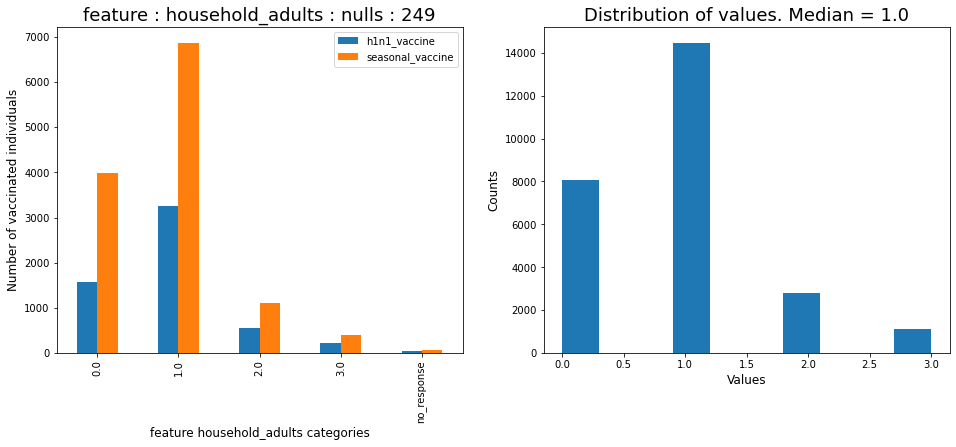

In [112]:
visualize(data, 'household_adults')

In [113]:
data['household_adults'] = fill_nulls(data['household_adults'], grouping_var=data['age_group'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\LAVANY~1\AppData\Local\Temp/ipykernel_34432/2333361200.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var[mask] = maxprob_val


##### census_msa

Number of Nulls: 0,
 Value Counts : 
MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64


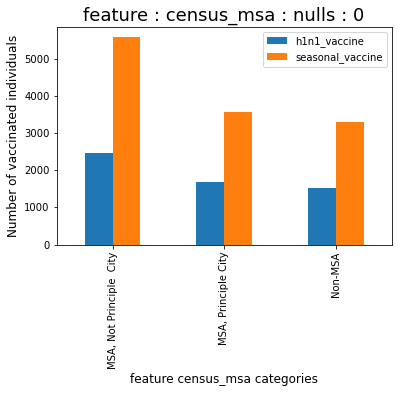

In [126]:
null_replacement(data, 'census_msa')

##### hhs_geo_region

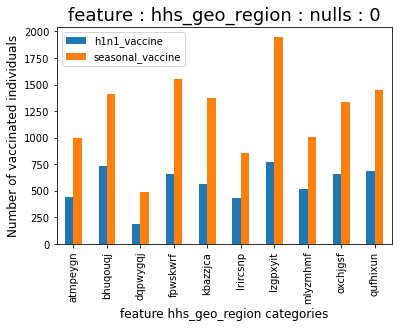

In [117]:
visualize(data, 'hhs_geo_region')

##### rent_or_own

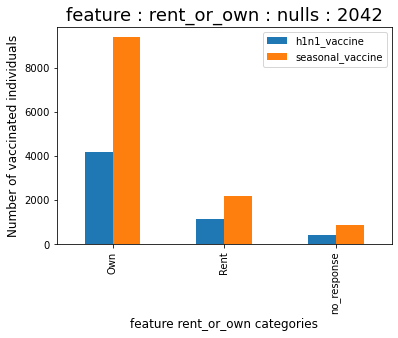

In [118]:
visualize(data, 'rent_or_own')

In [119]:
data['rent_or_own'].fillna('no_response', inplace=True)

##### income_poverty

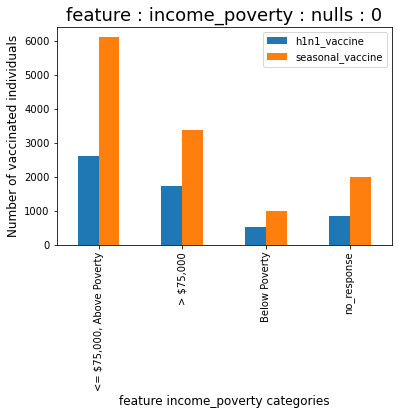

In [120]:
visualize(data, 'income_poverty')

##### employment_status

Number of Nulls: 0,
 Value Counts : 
Employed              13560
Not in Labor Force    10231
no_response            1463
Unemployed             1453
Name: employment_status, dtype: int64


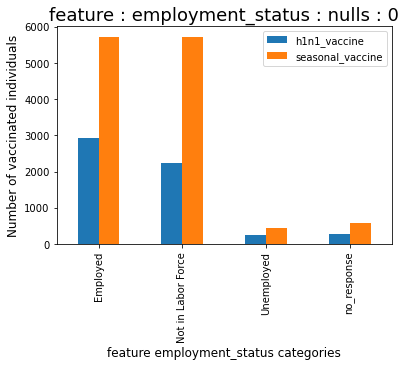

In [125]:
null_replacement(data, 'employment_status')

In [122]:
data['employment_status'].fillna('no_response', inplace=True)

In [123]:
data.isna().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

In [158]:
data.to_csv('../train_clean.csv', index=False)